In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd

In [4]:
df_train = pd.read_csv("trac2_CONVT_train.csv")
columnsTrain = df_train["text"]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import re
import string

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

def clean_text(text):
    text = text.lower()

    text = re.sub(r'[^a-z\s]', '', text)

    text = text.translate(str.maketrans('', '', string.punctuation))

    tokens = nltk.word_tokenize(text)

    clean_sentence = ' '.join(tokens)
    return clean_sentence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
emotionVocab = set()
listSentence = []
listWordVector = []

maxLengthSentence = 0

for column in columnsTrain:
    cleanColumn = clean_text(column)
    listSentence.append(cleanColumn)

for sentence in listSentence:
    listWord = sentence.split(" ")
    if "" in listWord:
        listWord.remove("")
    if len(listWord) > maxLengthSentence:
        maxLengthSentence = len(listWord)

    listWordVector.append(listWord)
    for word in listWord:
        emotionVocab.add(word)


PAD_TOKEN = "<PAD>"
EOS_TOKEN = "<EOS>"
SOS_TOKEN = "<SOS>"
UNK_TOKEN = "<UNK>"
listToken = [PAD_TOKEN, EOS_TOKEN, SOS_TOKEN, UNK_TOKEN]
emotionVocabList = list(emotionVocab) + listToken
sortedVocab = sorted(emotionVocabList)

print(sortedVocab)
print(listWordVector[0:5])

print(maxLengthSentence)

['<EOS>', '<PAD>', '<SOS>', '<UNK>', 'a', 'abalone', 'abandon', 'abandoned', 'abdicated', 'abdomen', 'abe', 'abilities', 'ability', 'abject', 'able', 'abolished', 'abortion', 'abotu', 'about', 'above', 'abraham', 'abroad', 'absence', 'absent', 'absentee', 'absolute', 'absolutely', 'absoulutely', 'abstract', 'absurd', 'absurdly', 'abundant', 'abundantly', 'abuout', 'abuse', 'abused', 'abusee', 'abuser', 'abusers', 'abuses', 'abusing', 'abusive', 'abut', 'ac', 'acceleration', 'accent', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'access', 'accessing', 'accident', 'accidentally', 'accidents', 'acclimate', 'acclimation', 'accompanied', 'accomplish', 'accomplished', 'accomplishes', 'accomplishing', 'accomplishment', 'accord', 'according', 'accordingly', 'accords', 'accoring', 'account', 'accountability', 'accountable', 'accounts', 'accurate', 'accusations', 'accused', 'accuser', 'accustomed', 'achieve', 'achieving', 'acknowledge', 'acknowledging', 'acquire', 'acquiring', 

In [7]:
listSentencePad = []
for wordVector in listWordVector:
    paddedWordVector = [SOS_TOKEN] + wordVector + ([PAD_TOKEN] * (maxLengthSentence - len(wordVector))) + [EOS_TOKEN]
    listSentencePad.append(paddedWordVector)
print(listSentencePad[0])
print(len(listSentencePad[0]))

['<SOS>', 'what', 'did', 'you', 'think', 'about', 'this', 'article', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PA

In [8]:
eng_word2int = {word: i for i, word in enumerate(sortedVocab)}
eng_int2word = {i: word for word, i in eng_word2int.items()}
print(eng_word2int)

{'<EOS>': 0, '<PAD>': 1, '<SOS>': 2, '<UNK>': 3, 'a': 4, 'abalone': 5, 'abandon': 6, 'abandoned': 7, 'abdicated': 8, 'abdomen': 9, 'abe': 10, 'abilities': 11, 'ability': 12, 'abject': 13, 'able': 14, 'abolished': 15, 'abortion': 16, 'abotu': 17, 'about': 18, 'above': 19, 'abraham': 20, 'abroad': 21, 'absence': 22, 'absent': 23, 'absentee': 24, 'absolute': 25, 'absolutely': 26, 'absoulutely': 27, 'abstract': 28, 'absurd': 29, 'absurdly': 30, 'abundant': 31, 'abundantly': 32, 'abuout': 33, 'abuse': 34, 'abused': 35, 'abusee': 36, 'abuser': 37, 'abusers': 38, 'abuses': 39, 'abusing': 40, 'abusive': 41, 'abut': 42, 'ac': 43, 'acceleration': 44, 'accent': 45, 'accept': 46, 'acceptable': 47, 'acceptance': 48, 'accepted': 49, 'accepting': 50, 'access': 51, 'accessing': 52, 'accident': 53, 'accidentally': 54, 'accidents': 55, 'acclimate': 56, 'acclimation': 57, 'accompanied': 58, 'accomplish': 59, 'accomplished': 60, 'accomplishes': 61, 'accomplishing': 62, 'accomplishment': 63, 'accord': 64, 

In [9]:
import numpy as np
wordTensor = []
for listSentence in listSentencePad:
    numericArray = []
    for word in listSentence:
        numericArray.append(eng_word2int[word])
    wordTensor.append(np.array(numericArray))
X_train = np.array(wordTensor)
print(wordTensor[0])

[   2 9623 2335 9873 8778   18 8789  533    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    0]


In [10]:
from numpy import unique
emotionColumnIndex = df_train.columns.get_loc("Emotion")
emotionPolarityColumnIndex = df_train.columns.get_loc("EmotionalPolarity")
emphathyColumnIndex = df_train.columns.get_loc("Empathy")

Y_train_reg = []
Y_train_class = []
instance = []
for i in range(0, len(df_train)):
    instance.append(df_train.iloc[i, emotionColumnIndex])

    instance.append(df_train.iloc[i, emphathyColumnIndex])
    Y_train_reg.append(instance)
    instance = []

for i in range(0, len(df_train)):

    instance.append(df_train.iloc[i, emotionPolarityColumnIndex])

    Y_train_class.append(instance)
    instance = []

Y_train_reg = np.array(Y_train_reg)
Y_train_class = np.array(Y_train_class)
nClass = len(unique(Y_train_class))
print(nClass)
print(Y_train_reg)
print(Y_train_class)

4
[[1 1]
 [3 4]
 [4 5]
 ...
 [3 4]
 [2 1]
 [2 1]]
[[1]
 [2]
 [2]
 ...
 [2]
 [0]
 [0]]


In [11]:
embedding_dim = 300
embedding_index = {}
with open("glove.6B.300d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector


In [12]:
# 2D Matrix dimension of Vocab Size x 300 (using glove 6B 300 dimension)

embedding_matrix = np.zeros((len(sortedVocab), embedding_dim))

for word, idx in eng_word2int.items():

    vector = embedding_index.get(word)

    if vector is not None:
        embedding_matrix[idx] = vector

    elif word == PAD_TOKEN or word == SOS_TOKEN or word == EOS_TOKEN:
        embedding_matrix[idx] = np.zeros(shape=(embedding_dim,))

    elif word == UNK_TOKEN :
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


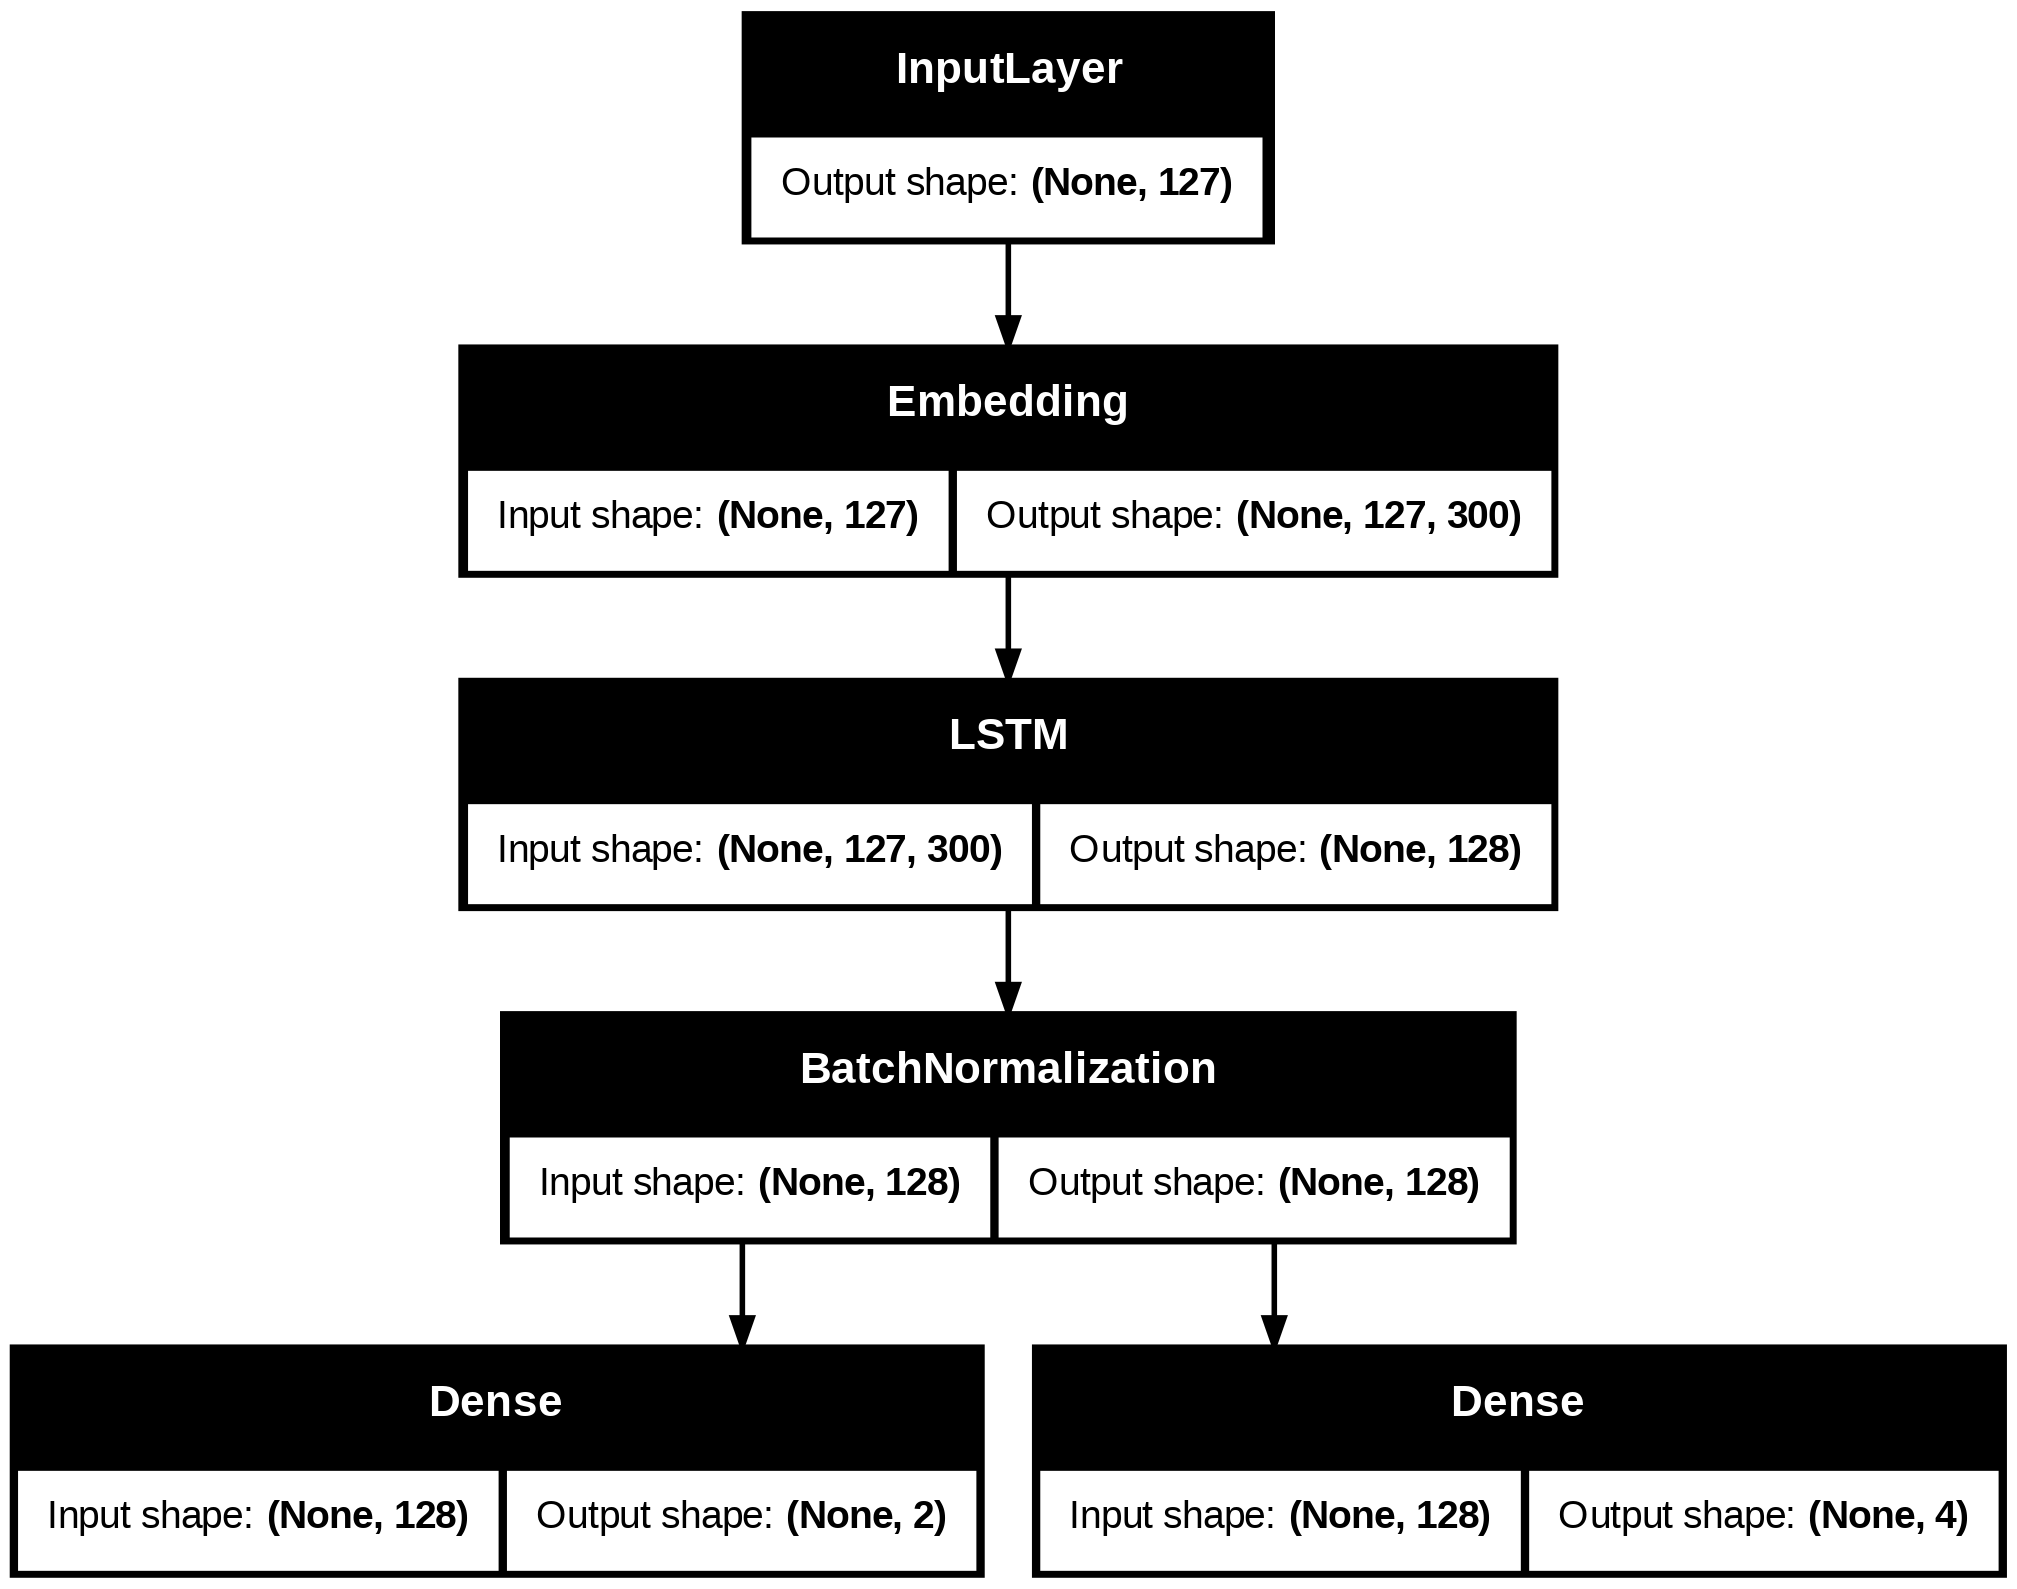

In [124]:
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import LSTM, Dense

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
inputs = Input(shape=(len(wordTensor[0]),))

embedding_layer = Embedding(
    input_dim = len(sortedVocab),
    output_dim = embedding_dim,
    embeddings_initializer = Constant(embedding_matrix),
    input_length = len(wordTensor[0]),
    trainable=True,
)(inputs)

lstmLayers = LSTM(128, activation='tanh', dropout = 0.2)(embedding_layer)
batchNormalizeLayer = BatchNormalization()(lstmLayers)
regression_output = Dense(2, name='regression')(batchNormalizeLayer)

classification_output = Dense(nClass, activation = 'softmax', name='classification')(batchNormalizeLayer)

modelNLP = Model(inputs = inputs, outputs=[regression_output, classification_output])

modelNLP.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'regression': 'mse',
        'classification': 'categorical_crossentropy'
    },
    metrics={
        'regression': ['mse'],
        'classification': ['accuracy']
    }
)

plot_model(modelNLP, to_file='model.png', show_shapes=True)

In [127]:
modelNLP.fit(
    X_train, [Y_train_reg, to_categorical(Y_train_class, num_classes = nClass)],
    epochs=50,
    batch_size=32,
    validation_split=0.2,

)

modelNLP.save("model_full5.keras")

Epoch 1/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - classification_accuracy: 0.9280 - classification_loss: 0.2147 - loss: 0.6263 - regression_loss: 0.4115 - regression_mse: 0.4116 - val_classification_accuracy: 0.6019 - val_classification_loss: 1.5962 - val_loss: 2.3131 - val_regression_loss: 0.7366 - val_regression_mse: 0.7361
Epoch 2/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - classification_accuracy: 0.9439 - classification_loss: 0.1775 - loss: 0.5883 - regression_loss: 0.4107 - regression_mse: 0.4108 - val_classification_accuracy: 0.6109 - val_classification_loss: 1.5582 - val_loss: 2.2538 - val_regression_loss: 0.7101 - val_regression_mse: 0.7104
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - classification_accuracy: 0.9413 - classification_loss: 0.1822 - loss: 0.5901 - regression_loss: 0.4079 - regression_mse: 0.4079 - val_classification_accuracy: 0.6096 - val_classification_loss: 1.5488 - val_loss: 2.2377 - val_regression_loss: 0.7046 - val_regression_mse: 0.7060
E

In [128]:
df_test = pd.read_csv("trac2_CONVT_dev.csv")
columnsTest = df_test["text"]
cleanColumn = []
listSentenceTest = []
for column in columnsTest:
    cleanColumn = clean_text(column)
    listSentenceTest.append(cleanColumn)
listWordVectorTest = []
for sentence in listSentenceTest:
    listWord = sentence.split(" ")
    if "" in listWord:
        listWord.remove("")
    listWordVectorTest.append(listWord)
listWordVectorTest[0:5]
listSentencePadTest = []
for wordVector in listWordVectorTest:
    paddedWordVector = [SOS_TOKEN] + wordVector + ([PAD_TOKEN] * (maxLengthSentence - len(wordVector))) + [EOS_TOKEN]
    listSentencePadTest.append(paddedWordVector)
print(listSentencePadTest[0])
print(len(listSentencePadTest[0]))

['<SOS>', 'hello', 'how', 'are', 'you', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>

In [129]:
import numpy as np
wordTensorTest = []
for listSentence in listSentencePadTest:
    numericArray = []
    for word in listSentence:
        if word in eng_word2int:
            numericArray.append(eng_word2int[word])
        else:
            numericArray.append(3)
    wordTensorTest.append(np.array(numericArray))
X_test = np.array(wordTensorTest)
print(wordTensorTest[0])

[   2 4041 4201  498 9873    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    0]


In [130]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
df_test = pd.read_csv("trac2_CONVT_dev.csv")
df_test["EmotionalPolarity"] = np.ceil(df_test['EmotionalPolarity'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
convoColumnTest = df_test["text"]

emotionColumnIndex = df_test.columns.get_loc("Emotion")
emotionPolarityColumnIndex = df_test.columns.get_loc("EmotionalPolarity")
emphathyColumnIndex = df_test.columns.get_loc("Empathy")

Y_test_reg = []
Y_test_class = []
instance = []
for i in range(0, len(df_test)):
    instance.append(df_test.iloc[i, emotionColumnIndex])

    instance.append(df_test.iloc[i, emphathyColumnIndex])
    Y_test_reg.append(instance)
    instance = []

for i in range(0, len(df_test)):
    instance.append(df_test.iloc[i, emotionPolarityColumnIndex])
    Y_test_class.append(instance)
    instance = []

Y_test_reg = np.array(Y_test_reg)
Y_test_class = np.array(Y_test_class)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[array([[1.6060492, 1.2059067],
       [1.3784117, 1.2878911],
       [1.9035546, 1.4422865],
       ...,
       [2.3729146, 2.1851578],
       [1.884364 , 1.7965167],
       [1.9786092, 1.8783662]], dtype=float32), array([[8.41548264e-01, 1.54655024e-01, 3.73096601e-03, 6.57549535e-05],
       [3.93243767e-02, 9.56628680e-01, 4.02815035e-03, 1.87316000e-05],
       [9.93717909e-01, 5.88936312e-03, 3.78775003e-04, 1.39691865e-05],
       ...,
       [1.39044612e-04, 9.48347850e-04, 9.98871982e-01, 4.05945029e-05],
       [1.29912701e-03, 9.98167872e-01, 4.93722560e-04, 3.92749753e-05],
       [2.90650129e-01, 7.08148837e-01, 1.13781868e-03, 6.32006704e-05]],
      dtype=float32)]
MSE per output: [0.55667689 1.14020607]
RMSE per output: [0.74610783 1.06780432]
MAE per output: [0.58680762 0.87737955]
R2 per output: [0.00147734 0.05368256]
[[ 51  90  16]
 [ 69 311  69]
 [  8 145 231]]


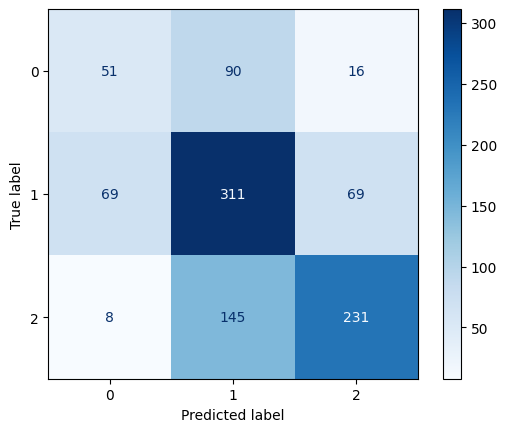

0.6050632651601798 0.598989898989899 0.5962736168882691 0.598989898989899


In [131]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model

y_pred = modelNLP.predict(X_test)
print(y_pred)

y_class_pred = np.argmax(y_pred[1], axis=1)


mse = mean_squared_error(Y_test_reg, y_pred[0], multioutput='raw_values')
print("MSE per output:", mse)

rmse = np.sqrt(mse)
print("RMSE per output:", rmse)

mae = mean_absolute_error(Y_test_reg, y_pred[0], multioutput='raw_values')
print("MAE per output:", mae)

r2 = r2_score(Y_test_reg, y_pred[0], multioutput='raw_values')
print("R2 per output:", r2)

cm = confusion_matrix(Y_test_class, y_class_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

precision = precision_score(Y_test_class, y_class_pred, average = "weighted")

recall = recall_score(Y_test_class, y_class_pred, average = "weighted")

f1 = f1_score(Y_test_class, y_class_pred, average = "weighted")

accuracy = accuracy_score(Y_test_class, y_class_pred)

print(precision, recall, f1, accuracy)
